In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [2]:
import pandas as pd
from datetime import datetime
import yfinance
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries


def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yfinance.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    file_name=quote+".csv"
    df.to_csv(file_name)
    if df.empty:
        ts = TimeSeries(key="dj0yJmk9WVJxNlRuYlZ3TXVjJmQ9WVdrOU1HSTNaMDVFZUZrbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWQ1", output_format="pandas")
        data= ts.get_daily_adjusted(symbol="NSE:" + quote, outputsize="full")
        data = data.head(503).iloc[::-1]
        data = data.reset_index()
        df = pd.DataFrame()
        df["Date"] = data["date"]
        df["Open"] = data["1. open"]
        df["High"] = data["2. high"]
        df["Low"] = data["3. low"]
        df["Close"] = data["4. close"]
        df["Adj Close"] = data["5. adjusted close"]
        df["Volume"] = data["6. volume"]
        file_name = quote + ".csv"
        df.to_csv(file_name, index=False)
    return file_name

RS
[*********************100%%**********************]  1 of 1 completed


C:\Users\ZUBAIR\AppData\Local\Temp\ipykernel_8808\3515439204.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(file, sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)


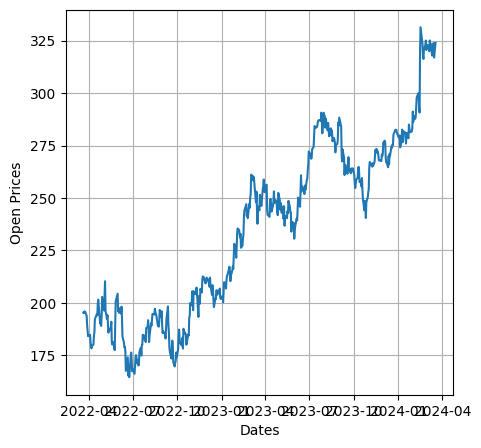

In [3]:
nm = input()
print(nm)
file = get_historical(nm)
# df=pd.read_csv(file)
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
data = pd.read_csv(file, sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
plt.figure(figsize=(5,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

In [4]:
#splitting the data into 70% training and 30% testing
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
# plt.figure(figsize=(5,5))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Open Prices')
# plt.plot(data['Open'], 'green', label='Train data')
# plt.plot(test_data['Open'], 'blue', label='Test data')
# plt.legend()

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# preprocessing training data
train = train_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
train_scaled = scaler.fit_transform(train)
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
#preprocessing testing data
test = test_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
test_scaled = scaler.fit_transform(test)
timesteps = 7
X_test = []
y_test = []
for i in range(timesteps, test.shape[0]):
    X_test.append(test_scaled[i-timesteps:i, 0]) 
    y_test.append(test_scaled[i, 0]) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [7]:
regressor1 = RandomForestRegressor(random_state=42)
regressor2 = GradientBoostingRegressor(random_state=42)
regressor3 = LinearRegression()

# Create a stacking regressor
stacked_regressor = StackingRegressor(
    estimators=[('rf', regressor1), ('gb', regressor2), ('lr', regressor3)],
    final_estimator=LinearRegression()
)

# Fit the ensemble model
stacked_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(random_state=42)),
                              ('lr', LinearRegression())],
                  final_estimator=LinearRegression())

predicted stock price for tomorrow:  [317.7155632]


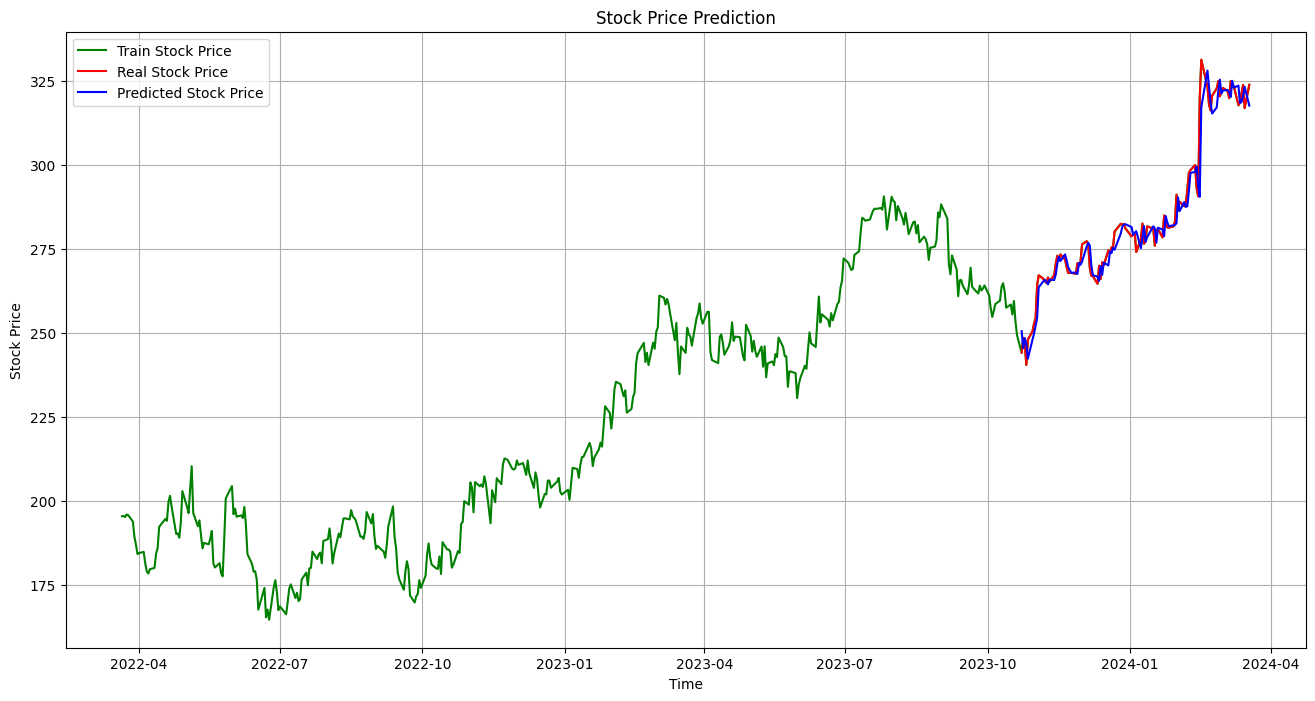

In [8]:
real_stock_price = test_data.iloc[:, 0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis=0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)
X_test = []
for i in range(timesteps, test_data.shape[0] + timesteps):
    X_test.append(test_inputs[i - timesteps:i, 0])

X_test = np.array(X_test)


X_test = X_test.reshape(X_test.shape[0], timesteps)

predicted_stock_price = stacked_regressor.predict(X_test)


predicted_stock_price = predicted_stock_price.reshape(-1, 1)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
print("predicted stock price for tomorrow: ",predicted_stock_price[len(predicted_stock_price)-1])

plt.figure(figsize=(16, 8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Train Stock Price')
plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

mse10 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse10))
mae10 = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae10))
rmse10 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse10))
r210 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r210))

MSE: 22.631329842195566
MAE: 3.130193569326958
RMSE: 4.757239729317366
R2 Score: 0.9550984956281281
